# Ytpak Video analyses
*Auther : Atique Ur Rehman*


### This notebook is part of a tutorial on [Scrapy](https://scrapy.org/). Scrapy was used to scrap data about videos from a video content providing website [YTPAK](https://www.ytpak.com/).
- First an initial search was made with a specific title, in our case "The kapil sharma Show"
- All the videos in the result were visited
- For each visited video, all the data including likes, views and comments were scrapped
- Then the suggessions of this visited video were visited recursively.

### Data
I ended up with two datasets from two different spiders
- First with the comments, likes, views and date
- Second with a list of videos and next suggested video

### Analyses
I have conducted three different analyses for just proof of concept
- Plot of No. of views VS No. of likes 
- Plot of the popularity of "Tha kapil sharma show" with time
- Plot of the sugesstion graph of the videos with hop counts(how far it was from original video). Using this graph we can visualize
    - How suggessions span to very different class of videos, and can take you places
    - How the related videos are clusstered with only < 10 hops, after that irrelevent videos starts
    - The diversity in the sugession algorithnm
    
**Note: ** I do not claing any of this data to be mine, it was scrapped for academic purposes only. Ytpak website have a *robots.txt* file the which on this day *5 March, 2017* reads:
```
User-agent: *
Allow: /

Sitemap: https://www.ytpak.com/sitemap_index.php
```
Which means the website allows the scrapping of all the content.
The code is released under MIT license, a copy of the license can be found in the root folder.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly
import networkx as nx
import matplotlib.dates
import ast
import re

from datetime import datetime
from plotly.graph_objs import *
from collections import defaultdict

%matplotlib inline
plt.style.use('ggplot')

In [3]:
frame = pd.read_csv("./results.csv")

### Description

In [4]:
frame.describe()

,data,type,id
count,9322,9322,9322
unique,9322,2,8022
top,{u'Mustafa B. Ketanci': u'Hem bitmeyen \u015fa...,meta,N9AHsZI9iSE
freq,1,8022,2


### Total data

In [5]:
print "Total Comments {}".format(np.sum(frame['type'] == 'comments'))
print "Total meta data items {}".format(np.sum(frame['type'] == 'meta'))

Total Comments 1300
Total meta data items 8022


### Pre-processing

In [6]:
frame['data'] = frame['data'].apply(lambda st : ast.literal_eval(st))

### Information included in meta data

In [7]:
first_meta_item = frame[frame['type'] == 'meta'].iloc[0]
meta_data = first_meta_item['data']
print meta_data.keys()

['description', 'title', 'views', 'dislikes', 'likes', 'date']


### Sanity check of data
- Plotting No. of views VS No. of like 

In [8]:
def get_clean_likes(st):
    val = st["likes"]
    val = val.replace(",", "").strip()
    return np.int64(val)

def get_clean_views(st):
    val = st["views"]
    val = val.replace(",", "")
    val = val.split(" ")[0]
    return np.int64(val)



meta_items = frame[frame['type'] == 'meta']
data = meta_items['data']
likes = data.apply(get_clean_likes)
views = data.apply(get_clean_views)

likes = np.array(likes)
views = np.array(views)

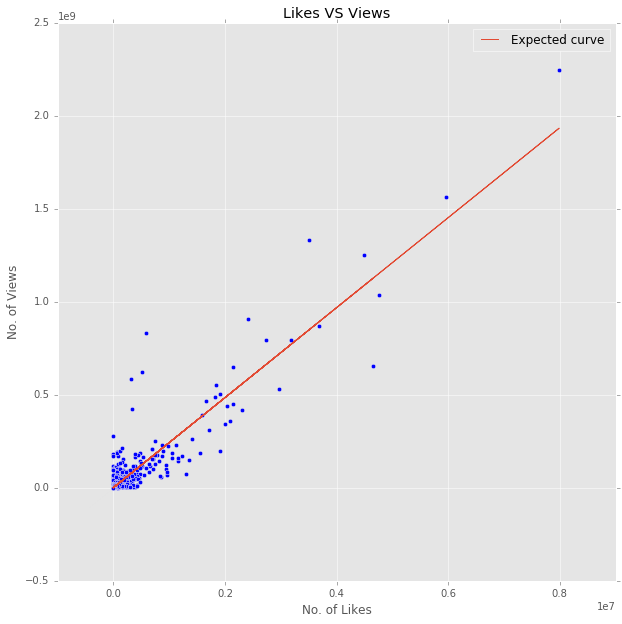

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(likes, views)
ax.set_title("Likes VS Views")
ax.set_xlabel("No. of Likes")
ax.set_ylabel("No. of Views")

a,b = np.polyfit(likes, views,1)
ax.plot(likes, a*likes + b, label = "Expected curve")
plt.legend()

### Popularity of 'The Kapil Sharma Show' with time

In [10]:
def get_clean_dates(st):
    val = st["date"]
    date = re.search("Published on (.*) \|", val).group(1)
    date = datetime.strptime(date, '%d %b %Y')
    return date
    
    
def is_kapils_video(st):
    title = st['title']
    des = st['description']
    return "kapil" in title.lower() or "kapil" in des.lower()
    
meta_items = frame[frame['type'] == 'meta']
data = meta_items['data']
related_data_mask = data.apply(is_kapils_video)
filterted_data = data[related_data_mask]

likes = filterted_data.apply(get_clean_likes)
views = filterted_data.apply(get_clean_views)
dates = filterted_data.apply(get_clean_dates)

likes = np.array(likes)
views = np.array(views)

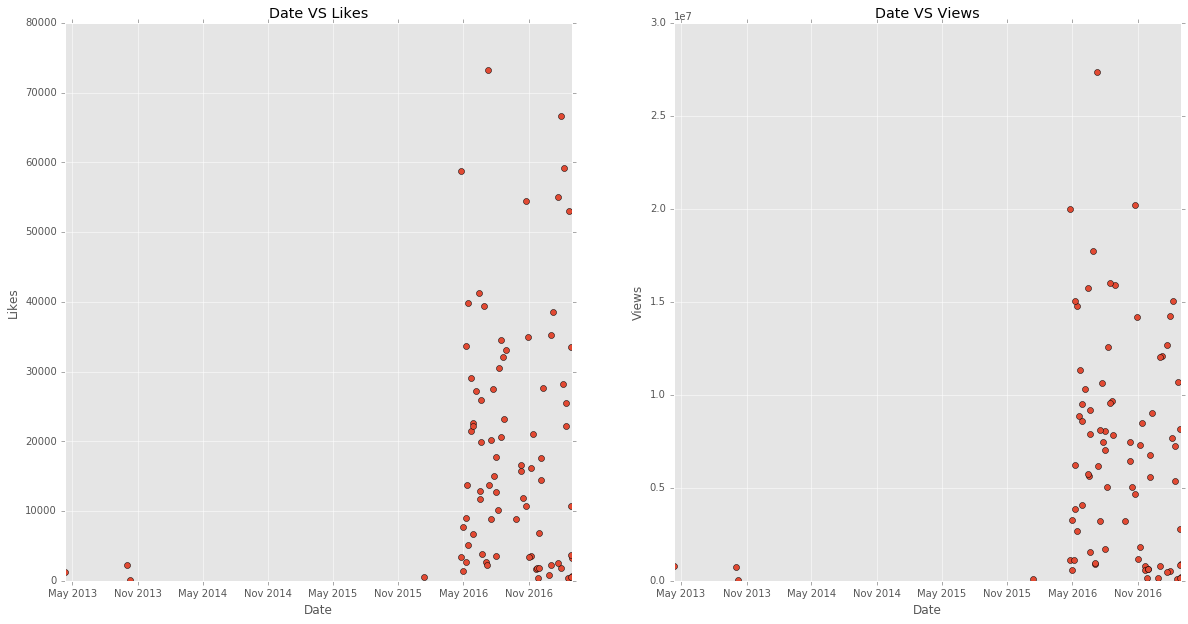

In [11]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].plot_date(dates, likes)
ax[0].set_title("Date VS Likes")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Likes")

ax[1].plot_date(dates, views)
ax[1].set_title("Date VS Views")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Views")

## Video Sugesstion Analyses

In [12]:
connection_frame = pd.read_csv("./connections.csv")

In [13]:
connection_frame.describe()

,likes,title,date,dislikes,views,refrer,id,description
count,1636,1636,1635,1635,1635,1634,1635,1501
unique,1349,1633,952,865,1634,959,1635,1402
top,0,مش صافيناز .رقص شرقي مصري .Hot Belly Dance,Published on 03 Mar 2017 | 1 day ago,0,\n9 views\n1 on YTPak\n,TAhNGYDNRt0,vi2tOCWuePw,SUBSCRIBE OUR CHANNEL FOR REGULAR UPLOADS OF \...
freq,34,3,7,53,2,10,1,34


### Calculating hop count (distance from searched video)

In [14]:
ids = connection_frame["id"]
refrer_ids = connection_frame["refrer"]
titles = connection_frame['title']

sugessted = defaultdict(list)
start = str(ids[0])
for i,r in zip(ids[1:], refrer_ids[1:]):
    sugessted[r].append(i)
    
def distance_count(root, sugessted_tree, hop_count = defaultdict(int), current_hop_count = 1):
    suggessions = sugessted_tree[root]
    
    for s in suggessions:
        hop_count[s] = current_hop_count
        distance_count(s, sugessted_tree,hop_count, current_hop_count +1)    
    return hop_count

hop_count = distance_count(start,sugessted)
hop_count[start] = 0

#### Initializing network graph

In [15]:
G=nx.Graph()

### Generating edges as a list and adding to graph

In [16]:
Nodes=ids
G.add_nodes_from(Nodes)
Edges=[(i,r) for i, r in zip(ids, refrer_ids)]
G.add_edges_from(Edges)

#### Plotting raw graph

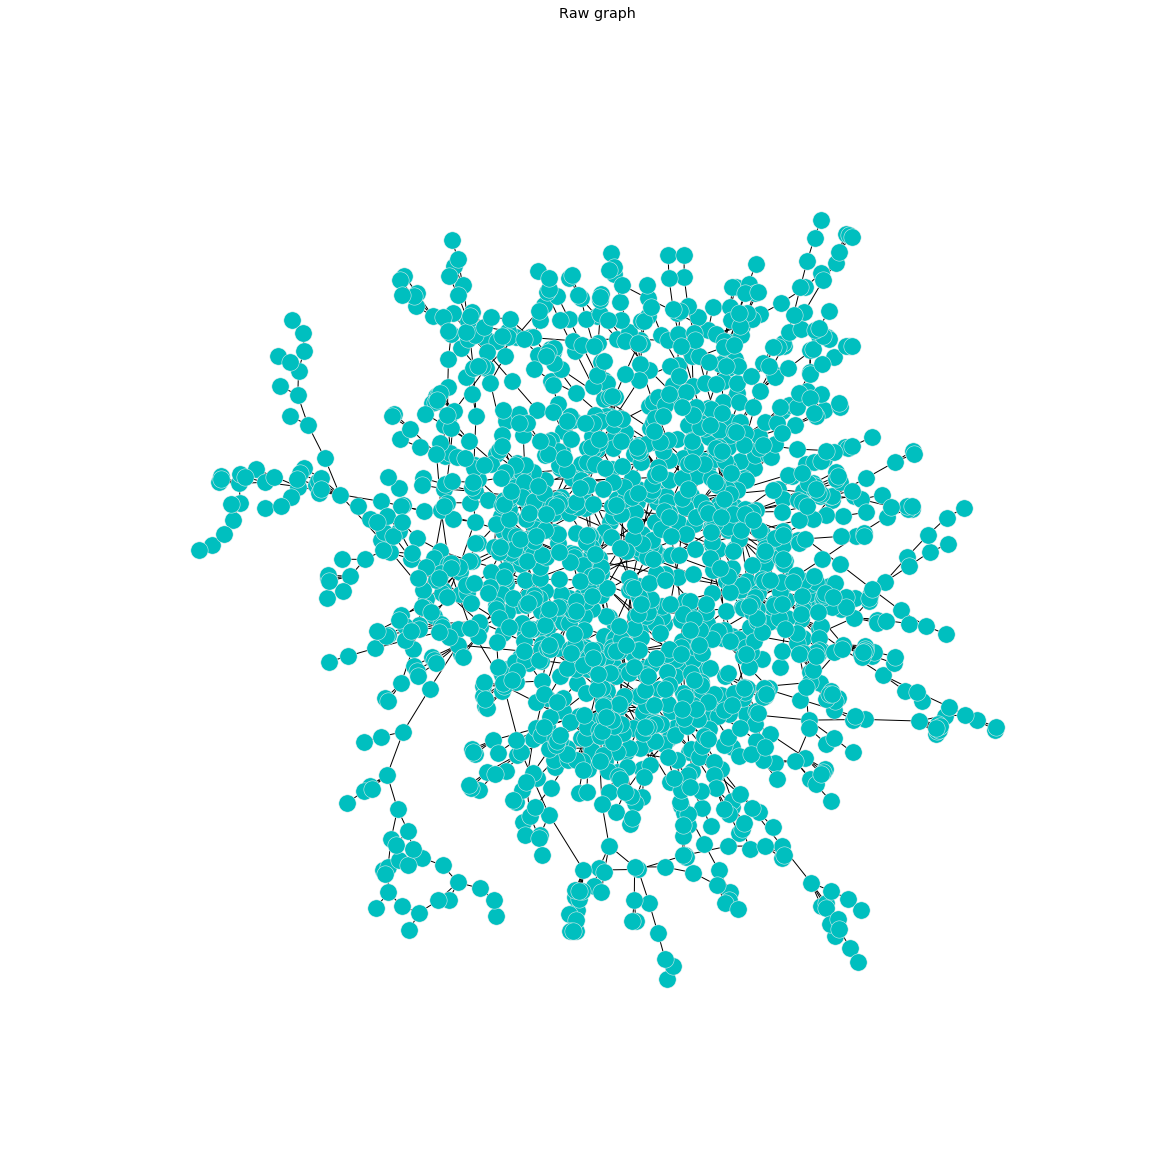

In [17]:
plt.figure(figsize=(20,20))
plt.title("Raw graph")
nx.draw(G, node_color='c',edge_color='k', with_labels=False)

### The graph above is not convaying any usefull information, so we have to add titles and colors to it
**These are some utility functions using plotly library for generaing nodes and edgses with colors, titles and other information.
These functions can be skipped for now if you jusr want a general idea of what is happening**

In [18]:
def scatter_nodes(pos, keys, hop_count, labels, color=None, size=10, opacity=1):
    # pos is the dict of node positions
    # labels is a list  of labels to be displayed when hovering the mouse over the nodes
    # color is the color for nodes. When it is set as None the Plotly default color is used
    # size is the size of the dots representing the nodes
    # opacity is a value between [0,1] defining the node color opacity
    
    trace = Scatter(
        x=[], 
        y=[], 
        mode='markers',
        marker=Marker(size=[], 
                      colorscale='Hot',
                      reversescale=False,
                      color=[],
                      colorbar=dict(
                            thickness=15,
                            title='Hop count from searched video',
                            xanchor='left',
                            titleside='right')))
    for k in keys:
        trace['x'].append(pos[k][0])
        trace['y'].append(pos[k][1])
        trace['marker']['color'].append(hop_count[k])
        
    attrib=dict(name='', text=labels , hoverinfo='text', opacity=0.9) # a dict of Plotly node attributes
    trace=dict(trace, **attrib)# concatenate the dict trace and attrib
    trace['marker']['size']=size
    return trace   

def scatter_edges(G, pos, line_color=None, line_width=1):
    trace = Scatter(x=[], y=[], mode='lines')
    for edge in G.edges():
        trace['x'] += [pos[edge[0]][0],pos[edge[1]][0], None]
        trace['y'] += [pos[edge[0]][1],pos[edge[1]][1], None]  
        trace['hoverinfo']='none'
        trace['line']['width']=line_width
        if line_color is not None: # when it is None a default Plotly color is used
            trace['line']['color']=line_color
    return trace  

### Using the above functions, generating titles, edges and nodes

In [19]:
pos=nx.fruchterman_reingold_layout(G)   
labels = [ "Title : " + titles[i] + "<br> Hop count : " + str(hop_count[k]) for i, k in enumerate(ids) ]
trace1=scatter_edges(G, pos)
trace2=scatter_nodes(pos, ids, hop_count, labels=labels)

### Setting up the layout 

In [20]:
width=1000
height=1000
axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )
layout=Layout(title= 'YTPAK videos suggession graph',  #
    font= Font(),
    showlegend=False,
    autosize=False,
    width=width,
    height=height,
    xaxis=XAxis(axis),
    yaxis=YAxis(axis),
    margin=Margin(
        l=40,
        r=40,
        b=85,
        t=100,
        pad=0,
       
    ),
    hovermode='closest',
#    plot_bgcolor='#EFECEA', #set background color            
    )

data=Data([trace1, trace2])
fig = Figure(data=data, layout=layout)

### Plotting the final graph 

In [21]:
plt.figure(figsize=(10,10))
py.iplot(fig, filename='YtpakSugessions')